# Autre Contributions :

{1} : https://github.com/Tirth27/Detecting-diabetic-retinopathy
{2} : https://github.com/getsanjeev/retina-features
{3} : https://github.com/getsanjeev/retinal-exudates-detection

In [2]:
import cv2

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [3]:
image_path = 'C:/Users/O/Desktop/im0032.ppm'  
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

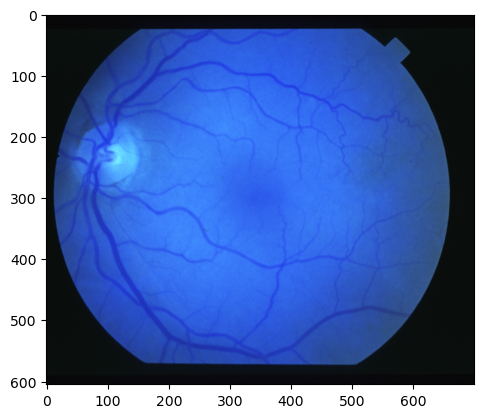

In [4]:
plt.imshow(image)

In [10]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

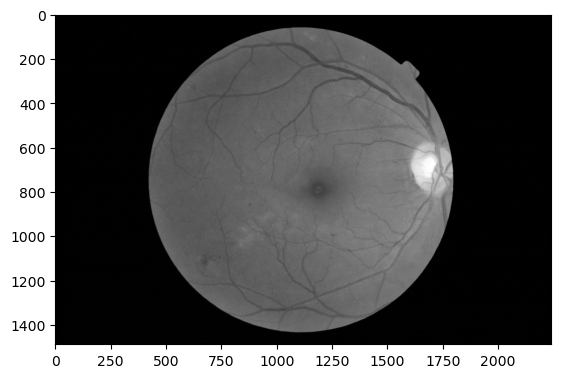

In [12]:
plt.imshow(gray_image, cmap='gray')

# Extraction des vaisseaux sanguins de l'oeil

In [5]:
def extract_bv(image):
    b,green_fundus,r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)

    # applying alternate sequential filtering (3 times closing opening)
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations =1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
    f5 = clahe.apply(f4)
#     f5 = f4
    # removing very small contours through area parameter noise removal
    ret,f6 = cv2.threshold(f5,155,255,cv2.THRESH_BINARY)
    mask = np.ones(f5.shape[:2], dtype="uint8") * 255
    contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=mask)
    ret,fin = cv2.threshold(im,20,255,cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)

    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv2.bitwise_not(newfin)
    xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
    xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)  
        if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)
    
    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)
    blood_vessels = cv2.bitwise_not(finimage)
    return blood_vessels , finimage

In [4]:

def to_string(n):
    l = len(str(n))
    return (4-l)* "0" + str(n)
# to_string(43)

## Testing on STARE project images

In [25]:

figs = []
for i in range(1,47):
    image_path = 'B:/im'+to_string(i)+'.ppm'
    test_image = cv2.imread(image_path , cv2.COLOR_BGR2RGB)
    
    ti = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    output_image ,fin  = extract_bv(test_image)
    ic = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    diff = cv2.subtract( ic ,ti)
    andd = cv2.bitwise_and(ic , ti)
    kernel = np.ones((605,700,3), dtype="uint8")*255
    diff = diff + kernel
    fig, axs = plt.subplots(2, 2, constrained_layout=True)

    fig.suptitle('Extracting blood vessels from image n* '+str(i), fontsize=16)
    axs[0 , 0].set_title('Image d\'origine')
    axs[0 , 0].imshow(ti , cmap="gray")
    axs[0 , 0].axis('off')
    axs[0 , 1].set_title('Vaisseaux detectes')
    axs[0 , 1].imshow(ic, cmap='gray')
    axs[0 , 1].axis('off')
    axs[1 , 0].set_title('difference / image')
    axs[1 , 0].imshow(diff, cmap='gray')
    axs[1 , 0].axis('off')
    axs[1 , 1].set_title('image coloree')
    axs[1 , 1].imshow(andd, cmap='gray')
    axs[1 , 1].axis('off')
        
    figs.append(fig)
with PdfPages('result_pdf.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig)
        plt.close()

NameError: name 'to_string' is not defined

In [6]:
def generate_mask(ti):
    output_image ,fin  = extract_bv(ti)
    

    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,7))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,1))
    kernel4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,1))
    img = cv2.erode(fin,kernel1)
    
    img2 = cv2.dilate(img , kernel1)
    img = cv2.erode(img2,kernel4)
    img2 = cv2.dilate(img , kernel4)
    img = cv2.erode(img2,kernel3)
    img2 = cv2.dilate(img , kernel3)
    img = cv2.erode(img2,kernel2)
    img2 = cv2.dilate(img , kernel2)
    img = cv2.erode(img2,kernel1)
    img2 = cv2.dilate(img , kernel1)
    
    ic = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    not_ = cv2.bitwise_not(ic)
    andd = cv2.bitwise_and(not_ , ti)
    return andd , ic , ti, output_image , img2

## Exemple sur une image de CHU

(-0.5, 2575.5, 1957.5, -0.5)

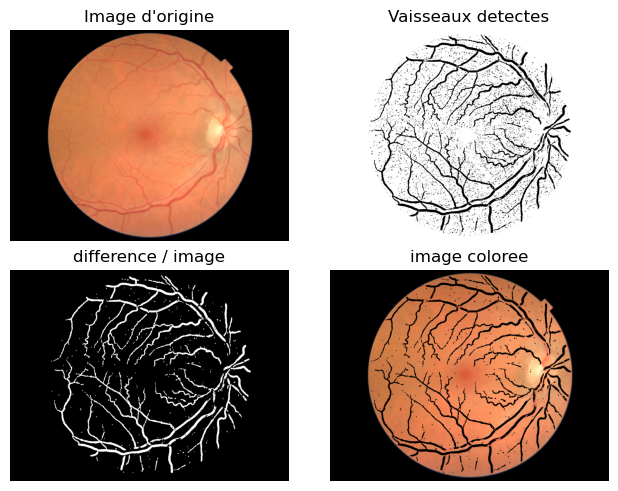

In [7]:
image_path = 'D:/snippet/CHU_OUJDA/6/10132_20220322_093039_Color_R_001.jpg'
img = cv2.imread(image_path, cv2.IMREAD_COLOR)

extracted_bv_from_real, colored , test_img , black_white, bv = generate_mask(img)

image = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(extracted_bv_from_real, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(2, 2, constrained_layout=True)
cv2.imwrite('D:/snippet/CHU_OUJDA/save/1.jpg' , image)

axs[0 , 0].set_title('Image d\'origine')
axs[0 , 0].imshow(image , cmap="gray")
axs[0 , 0].axis('off')
axs[0 , 1].set_title('Vaisseaux detectes')
axs[0 , 1].imshow(black_white, cmap='gray')
axs[0 , 1].axis('off')
axs[1 , 0].set_title('difference / image')
axs[1 , 0].imshow(bv, cmap='gray')
axs[1 , 0].axis('off')
axs[1 , 1].set_title('image coloree')
axs[1 , 1].imshow(image2, cmap='gray')
axs[1 , 1].axis('off')

# Calculer la similarite des images

In [8]:
def accuracy(img2,img1):
    res = cv2.absdiff(img1, img2)
    
    t =  np.sum(res == 0)
    #--- convert the result to integer type ---
    res = res.astype(np.uint8)
    
    #--- find percentage difference based on the number of pixels that are not zero ---
    percentage = (1- np.count_nonzero(res)/ res.size)*100
    return round(percentage,2)

Text(0.5, 1.0, 'Image de reference')

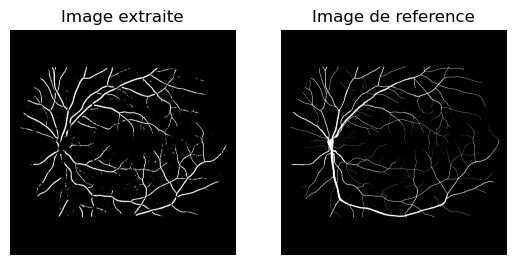

In [20]:
image_path = "B:/archive_tr/Train/images/01_dr_HRF.jpg"
reference_image_path = "B:/archive_tr/Train/masks/01_dr_HRF.jpg"

test_image = cv2.imread(image_path , cv2.COLOR_BGR2RGB)
reference_image = cv2.imread(reference_image_path , cv2.COLOR_BGR2RGB)

img2 ,ba ,an, na , img1 = generate_mask(test_image)

reference_image = reference_image[:,:,1]
res = accuracy( img1,reference_image)

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.axis("off")
plt.title("Image extraite")

plt.subplot(1,2,2)
plt.imshow(reference_image, cmap='gray')
plt.axis("off")
plt.title("Image de reference")


In [21]:
print("Le taux de similarite entre les deux images est : ", res)

Le taux de similarite entre les deux images est :  95.17


# DRIVE test

In [23]:
import os
path = 'B:/archive_tr/training/Images'
mask = 'B:/archive_tr/training/Masks'
paths = []
result = []
image_files = sorted(os.listdir(path))
for image_file in image_files :
    paths.append(os.path.join(path, image_file))
mask_files = sorted(os.listdir(mask))
for mask_file in mask_files:
    result.append(os.path.join(mask, mask_file))
print(len(result),len(paths))

73 73


In [27]:
def read(valid_path):
    if valid_path.endswith(".gif") :
        cap = cv2.VideoCapture(path )
        r , valid_image = cap.read()
        cap.release()
    else :
        valid_image = cv2.imread(valid_path)
    return valid_image

In [29]:
acc = []
figs = []
for i in range(20):
    image_path = paths[i]
    test_image = read(image_path)
    try : 
        andd , ic , ti, output_image , fin = generate_mask(test_image)
        fin = cv2.cvtColor(fin , cv2.COLOR_BGR2RGB)
        
        # the manually detected vessels
        valid_path = result[i]
        valid_image = read(valid_path)
        # calculate the accuracy
        res = accuracy(valid_image,fin)
        acc.append(res)
        print("Image "+ str(1+i)+" ===========> Accuracy " + str(res)+ " %" + " <============")

    except :    
        print('ERROR with image'+str(i))
        

print("maximum accuracy is ",  max(acc) )

Image 1 ===========> Accuracy 95.07 % <============
Image 2 ===========> Accuracy 95.21 % <============
Image 3 ===========> Accuracy 95.37 % <============
Image 4 ===========> Accuracy 94.77 % <============
Image 5 ===========> Accuracy 95.19 % <============
Image 6 ===========> Accuracy 95.82 % <============
Image 7 ===========> Accuracy 95.19 % <============
Image 8 ===========> Accuracy 96.46 % <============
Image 9 ===========> Accuracy 95.05 % <============
Image 10 ===========> Accuracy 95.64 % <============
Image 11 ===========> Accuracy 96.07 % <============
Image 12 ===========> Accuracy 95.54 % <============
Image 13 ===========> Accuracy 95.16 % <============
Image 14 ===========> Accuracy 96.16 % <============
Image 15 ===========> Accuracy 95.91 % <============
Image 16 ===========> Accuracy 94.14 % <============
Image 17 ===========> Accuracy 95.58 % <============
Image 18 ===========> Accuracy 95.03 % <============
Image 19 ===========> Accuracy 94.12 % <============
Im

## Pourcentage sur différents dataset

In [122]:

acc_HRF = acc[:35]
acc_DR = acc[35:50]
acc_CH = acc[50:]
a = sum(acc_HRF)/len(acc_HRF)
b = sum(acc_DR)/len(acc_DR)
c = sum(acc_CH)/len(acc_CH)
# print("####################################################################")
print("               ||")
print("ACCURACY HRF   ||      "+ str(round(a,2)) + " %                                     ##")
print("               ||")
# print("####################################################################")
print("               ||")
print("ACCURACY DRIVE ||      "+ str(round(b,2)) + " %                                     ##")
print("               ||")
# print("####################################################################")
print("               ||")
print("ACCURACY CHASE ||      "+ str(round(c,2))+ " %                                     ##")
print("               ||")
# print("####################################################################")


               ||
ACCURACY HRF   ||      95.31 %                                     ##
               ||
               ||
ACCURACY DRIVE ||      89.27 %                                     ##
               ||
               ||
ACCURACY CHASE ||      94.16 %                                     ##
               ||


## Test sur des images reelles

In [26]:
# importer les images :
pa = 'D:/snippet/CHU_OUJDA/6'
pas = []
image_files = sorted(os.listdir(pa))
for image_file in image_files :
    pas.append(os.path.join(pa, image_file))
    
#generer le masque de chaque image et voir le resultat
figs =[]
n = len(pas)
print(n)
for i in range(n):
    image_path = pas[i]
    test_image = read(image_path)

#     #generate image of blood vessels
    andd , ic , ti, output_image , fin = generate_mask(test_image)
    fig = plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Image d\'origine')
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Vaisseau sanguins detectes')
    plt.imshow(fin, cmap='gray')
    plt.axis('off')

    figs.append(fig)
    plt.close()

with PdfPages('OUAJDA_pdf.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig)
        plt.close()

# Validation des resultats
## 1.  Corrélation croisée normalisée (NCC - Normalized Cross-Correlation)

In [27]:
correlation = []
def correlationCoefficient(X, Y):
    n = X.size
    sum_X = X.sum()
    sum_Y = Y.sum()
    sum_XY = (X*Y).sum()
    squareSum_X = (X*X).sum()
    squareSum_Y = (Y*Y).sum()
    corr = (n * sum_XY - sum_X * sum_Y)/(np.sqrt((n * squareSum_X - sum_X * sum_X)* (n * squareSum_Y - sum_Y * sum_Y))) 
    return corr

for i in range(61):
    image_path = pas[i]
    test_image = cv2.imread(image_path)
    andd , ic , ti, output_image , fin = generate_mask(test_image)
#    Calculer la corelation avec l'image apres extraction des vaisseaux 
    im2 = np.array(test_image)/255
    im1 = np.array(andd)/255
    print ('{0:.6f}'.format(correlationCoefficient(im1, im2)))
    correlation.append('{0:.6f}'.format(correlationCoefficient(im1, im2)))
print("fin ")    

0.921575
0.893133
0.876787
0.887703
0.912484
0.916371
0.883880
0.947625
0.942240
0.919086
0.938538
0.957565
0.881482
0.883845
0.932597
0.939327
0.963546
0.903047
0.941811
0.942468
0.923017
0.917955
0.916198
0.924316
0.926031
0.931667
0.910563
0.942004
0.924044
0.925007
0.921506
0.895922
0.947488
0.887703
0.916371
0.944405
0.946915
0.947527
0.909159
0.908418
0.924424
0.959543
0.931669
0.920853
0.914414
0.936910
0.907287
0.950873
0.881482
0.935166
0.946660
0.938064
0.959574
0.954186
0.947072
0.889537
0.890155
0.926855
0.919016
0.917844
0.976767
fin 


In [37]:
def meanCorr(co):
    t=0
    for i in co :
        t += int(i[2:]) /1000000
    return t/len(co)
def countThat(co , a):
    t = 0 
    for i in co :
        if int(i[2:]) /1000000> a :
            t+=1
    return t

In [39]:
print("Minimum Correlation " ,min(correlation))
print("Maximum Correlation " ,max(correlation))
print("Mean Correlation " , meanCorr(correlation))
print("Nbr of images with corr > 90 % is ", countThat(correlation , 0.90))

Minimum Correlation  0.876787
Maximum Correlation  0.976767
Mean Correlation  0.9242570000000002
Nbr of images with corr > 90 % is  50


Valeur de la Corrélation Croisée Normalisée (NCC) : 0.27605336904525757
Valeur de la Corrélation Croisée Normalisée (NCC) : 0.1745


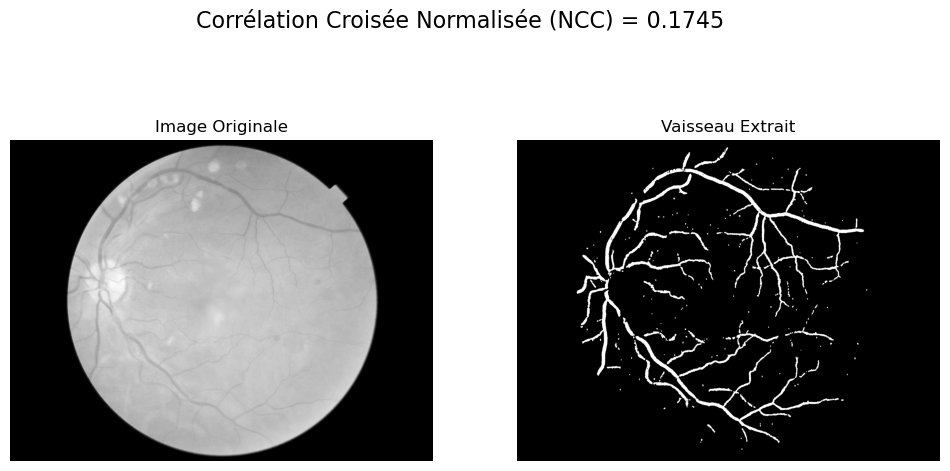

In [198]:
main()

In [199]:
print(correlation)

['0.887731', '0.808381', '0.795005', '0.843210', '0.873915', '0.887800', '0.814890', '0.918168', '0.919215', '0.887347', '0.874304', '0.933814', '0.815025', '0.814742', '0.905179', '0.873520', '0.944387', '0.867751', '0.909424', '0.904262', '0.885036', '0.890311', '0.891598', '0.885869', '0.898479', '0.904387', '0.889703', '0.913934', '0.841131', '0.837941', '0.885426', '0.768982', '0.922744', '0.843210', '0.887800', '0.917493', '0.915974', '0.917251', '0.872742', '0.875383', '0.890211', '0.941515', '0.871221', '0.864877', '0.845316', '0.909482', '0.871266', '0.932005', '0.815025', '0.904090', '0.918929', '0.908419', '0.930204', '0.919798', '0.923620', '0.850383', '0.855546', '0.845746', '0.849539', '0.886940', '0.953903']
